In [95]:
#==========================================================================
# Libraries
#==========================================================================

import pickle
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from scipy.integrate import solve_ivp
import scipy.io
import pandas as pd
import time
from gekko import GEKKO
from tqdm import tqdm
import copy

#==========================================================================
# Functions
#==========================================================================

import importlib
import utils.control.control  
importlib.reload(utils.control.control)
from utils.control.control import *

#==========================================================================
# Plotting settings
#==========================================================================
sel_LineWidth = 3
sel_LineWidth2 = 1.5
sel_MarkerWidth = 10
sel_LineWidthAxis = 1
sel_FontSize = 14  
# folder = '/Users/glavezzi/Library/CloudStorage/Box-Box/MIT/PROJETCS/SSEM/Draft/AAS24/figure' 

In [96]:
#==========================================================================
# Model from .json file
#==========================================================================

# filename = '../scenario-properties-test-no-run.pkl'
# filename = '../scenario-properties-test-no-run-mult.pkl'
# filename = '../scenario-properties-baseline-no-run_24_shells.pkl' # 15 species - 24 shells
# filename = '../scenario-properties-baseline-no-run_14_shells.pkl' # 15 species - 14 shells
filename = '../scenario-properties-baseline-no-run_5_shells.pkl' # 15 species - 5 shells
# filename = '../scenario-properties-test-no-run-policy.pkl' # 3 species - modified policy
with open(filename, 'rb') as f:
    baseline = pickle.load(f)
# baseline.equations

# Find the difference (symbols in equations but not in all_symbolic_vars) after 
# converting the list to a set for efficient difference calculation
difference_vars = baseline.equations.free_symbols - set(baseline.all_symbolic_vars)
ordered_difference_vars = sorted(list(difference_vars), key=lambda x: sort_key(str(x), baseline.species_names))

vars_dict = create_vars_dict(ordered_difference_vars)
# print("-----------------------------------------")
# for name, var_list in vars_dict.items():
#     print(f"{name}: {var_list}")

equations_flattened = [baseline.equations[i, j] for j in range(baseline.equations.cols) for i in range(baseline.equations.rows)]

# Parameters
N_shell = baseline.n_shells
R02 = baseline.R0_km

# Policy parameters
# for species_name, species_list in baseline.species_cells.items():
#     for species_properties in species_list:
#         print(species_properties.country, species_properties.mission_type, species_properties.mission_objective)

#==========================================================================
# Define symbolic variables based on loaded scenario
#==========================================================================
Pm_s, deltat_s, lam_s, u_var_s = extract_vars(vars_dict)
var_s = baseline.all_symbolic_vars

active_species_indices = int(len(lam_s)/N_shell)
active_species_per_shells = len(lam_s)

print("-----------------------------------------")
print(f"{baseline.species_length} species: {', '.join(baseline.species_names)}")
print(f"Number of shells: {baseline.n_shells}")
print(f"Number of active species: {active_species_indices}")
print(f"Number of active species per shell: {active_species_per_shells}")
print("-----------------------------------------")

#==========================================================================
# Define propagation function
#==========================================================================

func = sp.lambdify((var_s, u_var_s, np.concatenate((lam_s, Pm_s, deltat_s)).tolist()), equations_flattened, 'numpy')

def ode_func(t, x, func, u_var, mdd):
    return np.array(func(x, u_var, mdd)).flatten()


-----------------------------------------
15 species: S_148kg, S_750kg, S_1250kg, Su_260kg, Su_473kg, Sns, N_0.00141372kg, N_0.567kg, N_6kg, N_148kg, N_260kg, N_473kg, N_750kg, N_1250kg, B
Number of shells: 5
Number of active species: 6
Number of active species per shell: 30
-----------------------------------------


In [ ]:
#==========================================================================
# Selection and initialization of parameters for the simulation
#==========================================================================
np.random.seed(25) # Seed for reproducibility

# 1: IC from predefined array 
# 2: IC from MC2SSEM_population  
# 3: random or user selected for n species
# 4: for baseline/AMOS-23 scenario only, using .csv file from ADEPT
sel_ic = 3

# 1: PD ; 2: NMPC
sel_controller = 1

# PMD rate control: 0: no ; 1: yes 
sel_pmd_control = 0 # (ONLY with PD controller for NOW)

# Risk index (ONLY with PD controller for NOW)
sel_risk_index = 1 # 0: no risk index ; 1: CSI ; 2: UMPY ; 3: OAR

# 1: yes ; 0: no  
sel_launch_rate_plot =  0 # Launch rate plot
sel_pmd_plot =          0 # PMD plot
sel_deltat_plot =       0 # Orbital lifetime plot
sel_cumulative_plot =   1 # Cumulative plot

# Propagation time
tf_ss = 100.0
dur = tf_ss
Ts = 1.0
tspan = np.arange(0, dur+Ts, Ts)

# ODE tolerances
rtol = 1e-2
atol = 1e-2

if sel_controller == 1:
    print('PD controller selected')
elif sel_controller == 2:
    print('NMPC controller selected')    
    
if sel_pmd_control == 1:
    print('PMD controller selected')
    
#==========================================================================
# Species mean and std for initial population of each species (for sel_ic = 3)
# 1. User-selected: as many as the number of species
# 2. Random: uses the mean and std to assign them automatically to each species; 
#    e.g. first species is assigned the first mean and std, second species the 
#    second mean and std, etc.
#==========================================================================

# User selected
Species_mean = np.array([100, 200, 50])
Species_std = np.array([25, 40, 10])

# Random:
Species_mean, Species_std = assign_stats_to_species(baseline.species_names, Species_mean, Species_std)

#==========================================================================
# Controller reference values 
# 1. User-selected: as many as the number of species
# 2. Random: uses the ref_mult and ref_dot_mult to assign them automatically 
#    to each species; e.g. first species is assigned the first values, second 
#    species the second values, etc.
#==========================================================================
# Reference values for states
ref_mult = np.array([1, 0.5, 0.5])

# Reference values for rate of change of states
ref_dot_mult = np.array([0.5, 0, -0.8]) * 0

# Random:
ref_mult, ref_dot_mult = assign_stats_to_species(baseline.species_names, ref_mult, ref_dot_mult)

#==========================================================================
# PD Controller gains - Launch rate and ADR 
# 1. User-selected: as many as the number of species
# 2. Random: uses the K_p and K_d to assign them automatically to each species; 
#    e.g. first species is assigned the first values, second species the second values, etc.
#==========================================================================
K_p = np.array([1 * 0,
                1 * 1,
                1 * 1]) * 1

K_d = np.array([1 * 0.5,
                1 * 1,
                1 * 1]) * 0

# Random:
K_p, K_d = assign_stats_to_species(baseline.species_names, K_p, K_d)

#==========================================================================
# Control Settings - NMPC
#==========================================================================
# MPC - Prediction horizon steps
Tp = 5

# MPC - Control horizon steps
Tc = 3 # Positive integer, m, between 1 and p, inclusive, 
# where p is equal to PredictionHorizon. In this case, the controller computes 
# m free control moves occurring at times k through k+m-1, and holds the controller 
# output constant for the remaining prediction horizon steps from k+m through k+p-1. 
# Here, k is the current control interval.
# The product of Tp and Ts is the prediction time; that is,
# how far the controller looks into the future.

#==========================================================================
# Active Debris Removal (ADR) - Saturation Functions 
# ==========================================================================
# Note:
# - A value of zero is automatically assigned for active satellites (S) species.
# - Choose the values of saturation to assignt to the remaining species.
# - If only one saturation value,same value is assigned to all species.
#==========================================================================

# Time-dependent
satur1 = lambda t: -(2 + np.floor(t / 10) * 5) # increase every 10 years
satur2 = lambda t: -(2 + np.floor(t / 5) * 5) # increase every 5 years

# Constant
# satur1 = lambda t: - 10 + 0 * t
# satur2 = lambda t: - 20 + 0 * t

satur = assign_saturations(baseline.species_names, [satur1]) 

#==========================================================================
# Initial conditions 
# (TO BE UPDATED w/ new initial pop and launch traffic)
#==========================================================================

print("-----------------------------------------")
print('Initial population')

if sel_ic == 1:
    # Mean and standard deviation values
    S_mean = 142
    S_std = 497
    D_mean = 73
    D_std = 79
    N_mean = 280
    N_std = 354

    # Generate random values and create initial conditions
    S_rand = randn2(N_shell)
    x0_S = np.abs(np.round(S_mean + S_std * S_rand)).astype(int)
    D_rand = randn2(N_shell)
    x0_D = np.abs(np.round(D_mean + D_std * D_rand)).astype(int)
    N_rand = randn2(N_shell)
    x0_N = np.abs(np.round(N_mean + N_std * N_rand)).astype(int)

    # Combine initial conditions
    x0 = np.concatenate((x0_S, x0_N, x0_D))
    spec_names = ["Su", "N", "D"]

    # Create pandas DataFrame (equivalent to MATLAB's table)
    df = pd.DataFrame(x0.reshape((3,N_shell)).T, columns=spec_names)
    # print(df.to_string(index=False)) # Print DataFrame without index

    # Print table with shell numbers (optional)
    df_with_shell = pd.DataFrame(np.column_stack((np.arange(1, N_shell+1),x0.reshape((3,N_shell)).T)), 
                                   columns=['Shell'] + spec_names)
    print(df_with_shell.to_string(index=False)) # Print DataFrame without index

elif sel_ic == 2:
    # change order of Su with S
    baseline.species_types = [
        'Su' in baseline.species_cells and baseline.species_cells['Su'],
        'D' in baseline.species_cells and baseline.species_cells['D'],
        'N' in baseline.species_cells and baseline.species_cells['N'],
        'S' in baseline.species_cells and baseline.species_cells['S'],
        'B' in baseline.species_cells and baseline.species_cells['B'],
        'U' in baseline.species_cells and baseline.species_cells['U']
    ]
    mass_lb = 0.00141372; # lower bound of mass class for object binning (inclusive), 1 cm diameter Al sphere
    mass_ub = 100000; # upper bound of mass class for object binning (exclusive, except for top mass bin, which is inclusive)
    for species_name, species_list in baseline.species_cells.items():
        for species_properties in species_list:
            species_properties.mass_lb = mass_lb
            species_properties.mass_ub = mass_ub
    init_mat = scipy.io.loadmat('initialized.mat')
    sats = init_mat['sats']
    x0 = MC2SSEM_population(sats, baseline)
    spec_names = ["Su", "N", "D"]

    # Create pandas DataFrame (equivalent to MATLAB's table)
    df = pd.DataFrame(x0.reshape((3,N_shell)).T, columns=spec_names)
    # print(df.to_string(index=False)) # Print DataFrame without index
    x0_S = df['Su'].values
    x0_D = df['D'].values
    x0_N = df['N'].values

    # Print table with shell numbers (optional)
    df_with_shell = pd.DataFrame(np.column_stack((np.arange(1, N_shell+1),x0.reshape((3,N_shell)).T)), 
                                   columns=['Shell'] + spec_names)
    print(df_with_shell.to_string(index=False)) # Print DataFrame without index

elif sel_ic == 3:
    x0 = []
    for i1 in range(baseline.species_length):
        # Generate random values and create initial conditions
        Species_rand = randn2(N_shell)
        # Combine initial conditions
        x0 = np.concatenate((x0, np.abs(np.round(Species_mean[i1] + Species_std[i1] * Species_rand))))

    x0 = x0.astype(int)
    # Create pandas DataFrame (equivalent to MATLAB's table)
    df = pd.DataFrame(x0.reshape((baseline.species_length,N_shell)).T, columns=baseline.species_names)
    # print(df.to_string(index=False)) # Print DataFrame without index

    # Print table with shell numbers (optional)
    df_with_shell = pd.DataFrame(np.column_stack((np.arange(1, N_shell+1),x0.reshape((baseline.species_length,N_shell)).T)), 
                                    columns=['Shell'] + baseline.species_names)
    print(df_with_shell.to_string(index=False)) # Print DataFrame without index

elif sel_ic == 4:
    # Initial population baseline.x0 as pd.DataFrame: 
    x0 = baseline.x0.T.values.flatten()

    # Print table with shell numbers (optional)
    df_with_shell = pd.DataFrame(np.column_stack((np.arange(1, N_shell+1),x0.reshape((baseline.species_length,N_shell)).T)), 
                                    columns=['Shell'] + baseline.species_names)
    print(df_with_shell.to_string(index=False)) # Print DataFrame without index

    # Future launch model baseline.FLM_steps as a pd.DataFrame OR 
    # If baseline.baseline == False, the baseline.FLM_steps are 
    # converted into lambda functions for each species, 
    # by using baseline.future_launch_model(baseline.FLM_steps):
    non_debris_species = {key: value for key, value in baseline.species.items() if key != 'debris'}
    x0_lam_no_noise = []
    for species_name, species_list in non_debris_species.items():
        for species_properties in species_list:
            x0_lam_no_noise.append( np.array(baseline.FLM_steps[species_properties.sym_name]).reshape(baseline.n_shells, baseline.steps) )
    x0_lam_no_noise = np.concatenate(x0_lam_no_noise, axis=0)
    x0_lam = x0_lam_no_noise

    # for species_name, species_list in baseline.species_cells.items():
    #     print(species_name)
    #     for species_properties in species_list:
    #         print(len(species_properties.lambda_funs))

#==========================================================================
# Reference values
#==========================================================================

if sel_ic == 3 or sel_ic == 4:
    ref = []
    ref_dot = []
    for i1 in range(baseline.species_length):
        start_idx = i1 * baseline.n_shells
        end_idx = start_idx + baseline.n_shells
        ref = np.concatenate((ref, x0[start_idx:end_idx] * ref_mult[i1]))
        ref_dot = np.concatenate((ref_dot, np.ones(baseline.n_shells) * ref_dot_mult[i1]))
else:
    ref_S = x0_S * ref_mult[0] * 1
    ref_D = x0_D * ref_mult[1] * 1
    ref_N = x0_N * ref_mult[2] * 1
    ref_S_dot = np.ones(N_shell) * ref_dot_mult[0] * 0
    ref_D_dot = np.ones(N_shell) * ref_dot_mult[1] * 0
    ref_N_dot = np.ones(N_shell) * ref_dot_mult[2] * 0

    ref = np.concatenate([ref_S, ref_N, ref_D])
    ref_dot = np.concatenate([ref_S_dot, ref_N_dot, ref_D_dot])


PD controller selected
-----------------------------------------
Initial population
 Shell  S_148kg  S_750kg  S_1250kg  Su_260kg  Su_473kg  Sns  N_0.00141372kg  N_0.567kg  N_6kg  N_148kg  N_260kg  N_473kg  N_750kg  N_1250kg  B
     1      128       70        94       101        99  104             177        203    143       62       39       50       47        49 31
     2      105      112        70        89       101   55             251        206    215       45       57       54       59        47 42
     3       85       96        97       113        93  115             218        226    180       50       36       53       56        64 52
     4       78      104       105        91       170   95             196        238    202       37       46       56       37        51 40
     5       94       92        75       124       101   96             178        237    269       54       55       48       60        43 60


In [98]:
#==========================================================================
# Launch rate - selection:
# 1. Null 
#       lam_f1(t)
# 2. Time and shell constant based on constant multiplier of the initial population
#       lam_f2(t, const, ref, active_species_indices, N_shell)
# 3. Time and shell varying based on random multiplier of the initial population 
#       lam_f3(t, ref, active_species_per_shells)
# 4. Time and shell varying based on mean and std 
#       lam_f4(t, active_species_per_shells)
# 5. Time and shell based on cosinusoidal function 
#       lam_f5(t, ref, active_species_per_shells)
#==========================================================================

# Initialize arrays (# species in i-th shells x # time steps)
x0_lam_no_noise = np.zeros((active_species_per_shells, len(tspan)))
x0_lam = np.zeros((active_species_per_shells, len(tspan)))

# Evaluate lambda functions for each time step
for i1 in range(len(tspan)):
    x0_lam_no_noise[:, i1] = lam_f1(tspan[i1])
    # x0_lam_no_noise[:, i1] = lam_f2(tspan[i1],[0.2,0.2,0.1,0.1,0,0], ref, active_species_indices, N_shell)
    # x0_lam[:, i1] = lam_f1(tspan[i1]) 
x0_lam = x0_lam_no_noise

# Plot
if sel_launch_rate_plot == 1:
    launch_rate_plot(baseline, active_species_indices, x0_lam, x0_lam_no_noise, sel_LineWidth, sel_LineWidthAxis, sel_FontSize)

# # Check output
# i1 = 3
# print(x0_lam_no_noise[i1])
# print(sum(x0_lam_no_noise[:,i1]))

#==========================================================================
# PMD - selection:
# 1. Time and shell constant 
#       pmd_f1(t,const, active_species_indices, N_shell)
# 2. Increasing over time, constant for each shell
#       pmd_f2(t,lower_bound,upper_bound, active_species_indices, N_shell, tspan)
# 3. Increasing over time with randomness, constant for each shell
#       pmd_f3(t,lower_bound,upper_bound, active_species_indices, N_shell)
#==========================================================================

# Initialize arrays (# species in i-th shells x # time steps)
PMD_no_noise = np.zeros((active_species_per_shells, len(tspan)))
PMD = np.zeros((active_species_per_shells, len(tspan)))

# Evaluate lambda functions for each time step
for i1 in range(len(tspan)):
    PMD_no_noise[:, i1] = pmd_f1(tspan[i1],[0.9,0.9,0.9,0.9,0.9,0.9],active_species_indices, N_shell)
    # PMD_no_noise[:, i1] = pmd_f2(tspan[i1],[0.6,0.7,0.8,0.9,0.9,0.9],[0.999,0.999,0.999,0.999,0.999,0.999], active_species_indices, N_shell, tspan)
    # PMD_no_noise[:, i1] = pmd_f3(tspan[i1],[0.6,0.7,0.8,0.9,0.9,0.9],[0.999,0.999,0.999,0.999,0.999,0.999], active_species_indices, N_shell)
    # PMD[:, i1] = pmd_f1(tspan[i1],[0.9,0.9,0.9,0.9,0.8,0.8],active_species_indices, N_shell)
PMD = PMD_no_noise

# Used with sel_pmd_control = 1
PMD_no_noise_orig = copy.deepcopy(PMD_no_noise)
PMD_orig = copy.deepcopy(PMD)

# Plot
if sel_pmd_plot == 1:
    pmd_plot(baseline, active_species_indices, PMD, PMD_no_noise, sel_LineWidth, sel_LineWidthAxis, sel_FontSize)

#==========================================================================
# Orbital lifetime [years] - selection:
# 1. Time and shell constant 
#      deltat_f1(t,const, active_species_indices, N_shell)  
#==========================================================================

# Initialize arrays (# species in i-th shells x # time steps)
deltat_no_noise = np.zeros((active_species_per_shells, len(tspan)))
deltat = np.zeros((active_species_per_shells, len(tspan)))

# Evaluate lambda functions for each time step
for i1 in range(len(tspan)):
    deltat_no_noise[:, i1] = deltat_f1(tspan[i1],[8,8,8,8,8,8], active_species_indices, N_shell)
    # deltat[:, i1] = deltat_f1(tspan[i1],[8,8,8,8,8,8], active_species_indices, N_shell)
deltat = deltat_no_noise

# Plot
if sel_deltat_plot == 1:
    deltat_plot(baseline, active_species_indices, deltat, deltat_no_noise, sel_LineWidth, sel_LineWidthAxis, sel_FontSize)

#==========================================================================
# Additional parameters selection (TO DO, if needed)
#==========================================================================

# Alpha_no_noise = 0.15 * np.ones_like(tspan) 
# alpha_active_no_noise = 0.015 * np.ones_like(tspan) 
# Delta_no_noise = 5 * np.ones_like(tspan)

# Alpha = Alpha_no_noise + 0 * Alpha_no_noise / 3.5 * np.random.randn(*tspan.shape)
# alpha_active = alpha_active_no_noise + 0 * alpha_active_no_noise / 3.5 * np.random.randn(*tspan.shape)
# Delta = Delta_no_noise + 0 * Delta_no_noise / 3 * np.random.randn(*tspan.shape)

In [99]:
#==========================================================================
# Propagation with control
#==========================================================================

x00 = x0

if sel_risk_index == 1:
    csi_species = np.zeros((len(tspan),baseline.species_length))
    csi_total = np.zeros(len(tspan))
    csi_species_nc = np.zeros((len(tspan),baseline.species_length))
    csi_total_nc = np.zeros(len(tspan))
elif sel_risk_index == 2: # TO DO
    1
elif sel_risk_index == 3: # TO DO
    1

if sel_controller == 1:
#==========================================================================
# PD
#==========================================================================
    # Initialize arrays
    x_prop_all = np.zeros((len(tspan), baseline.species_length*N_shell))
    u_all = np.zeros((len(tspan), baseline.species_length*N_shell))
    x_prop_all[0, :] = x00

    # Start timing
    start_time = time.time()

    for i1 in range(len(tspan) - 1):
        md_no_noise = np.concatenate((x0_lam_no_noise[:, i1], PMD_no_noise[:, i1], deltat_no_noise[:, i1]))
        md = np.concatenate((x0_lam[:, i1], PMD[:, i1], deltat[:, i1]))

        sol = solve_ivp(ode_func, 
                        (tspan[i1], tspan[i1+1]), 
                        x00, 
                        method=baseline.integrator,
                        args=(func,np.zeros(len(u_var_s)),md_no_noise),
                        rtol=rtol, atol=atol)
        x_prop = sol.y[:, -1]
        
        # TO BE USED ONLY WITH x00a below
        # sol_actual = solve_ivp(ode_func, 
        #                 (tspan[i1], tspan[i1+1]), 
        #                 x00, 
        #                 method=baseline.integrator,
        #                 args=(func,np.zeros(len(u_var_s)),md),
        #                 rtol=rtol, atol=atol)
        # x_prop_actual = sol_actual.y[:, -1]

        x_dot_prop = np.array(func(x_prop, np.zeros(len(u_var_s)), md_no_noise)).flatten()

        u_list = []
        for i2 in range(baseline.species_length):
            start_idx = i2 * baseline.n_shells
            end_idx = start_idx + baseline.n_shells
            if baseline.species_names[i2].startswith('S'): # Launch rate controllers
                u_eval = np.maximum(K_p[i2] * (ref[start_idx:end_idx] - x_prop[start_idx:end_idx]) + K_d[i2] * (ref_dot[start_idx:end_idx] - x_dot_prop[start_idx:end_idx]), 0)
                u_list = np.concatenate([u_list, u_eval])
            else: # ADR controllers
                u_eval = np.minimum(K_p[i2] * (ref[start_idx:end_idx] - x_prop[start_idx:end_idx]) + K_d[i2] * (ref_dot[start_idx:end_idx] - x_dot_prop[start_idx:end_idx]), 0)
                if np.sum(u_eval) < satur[i2](tspan[i1+1]):
                    u_eval = u_eval * (satur[i2](tspan[i1+1]) / np.sum(u_eval))
                u_list = np.concatenate([u_list, u_eval])

        # PMD
        if sel_pmd_control == 1:
            PMD_temp = 0
            for i2 in range(baseline.species_length):
                start_idx = i2 * baseline.n_shells
                end_idx = start_idx + baseline.n_shells
                if not baseline.species_names[i2].startswith('S'):
                    if np.sum(x_prop[start_idx:end_idx]) > np.sum(x_prop_all[i1,start_idx:end_idx]):
                        PMD_temp = PMD_temp + 1
            for i3 in range(active_species_per_shells):
                if PMD_temp > 0:
                    if PMD_no_noise[i3,i1] < 0.95 and PMD[i3,i1] < 0.95:
                        PMD_no_noise[i3,i1+1] = PMD_no_noise[i3,i1] + 0.01
                        PMD[i3,i1+1] = PMD[i3,i1] + 0.01
                    else:
                        PMD_no_noise[i3,i1+1] = 0.95
                        PMD[i3,i1+1] = 0.95
                else:
                    PMD_no_noise[i3,i1+1] = PMD_no_noise[i3,i1]
                    PMD[i3,i1+1] = PMD[i3,i1]

        # x00a = x_prop_actual + u_list
        sol_actual_last = solve_ivp(ode_func, 
                        (tspan[i1], tspan[i1+1]), 
                        x00, 
                        method=baseline.integrator,
                        args=(func, u_list, md),
                        rtol=rtol, atol=atol)
        x_prop_actual_last = sol_actual_last.y[:, -1]
        x00b = x_prop_actual_last # x00b
        # print(np.sum(x00a)-np.sum(x00b))

        if sel_risk_index == 1:
            csi_species[i1], csi_total[i1] = cum_CSI(x00, baseline)
        elif sel_risk_index == 2: # TO DO
            1
        elif sel_risk_index == 3: # TO DO
            1

        x00 = x00b
        x_prop_all[i1+1, :] = x00
        u_all[i1+1, :] = u_list 
        
    # End timing
    propagation_time = time.time() - start_time 
    mvHistory = u_all.T
    xHistory = x_prop_all.T

elif sel_controller == 2:
#==========================================================================
# NMPC
#==========================================================================

    def myCostFunction(x, u, r):
        """
        Custom cost function for nonlinear MPC.
        """
        J = np.sum((x - r)**2)
        # J = np.sum(np.abs(x - r))
        return J 

    nx = len(var_s)
    nu = len(u_var_s)
    nd = len(lam_s) + len(Pm_s) + len(deltat_s)

    # Create GEKKO model (similar to nlmpc in MATLAB)
    m = GEKKO(remote=False) 

    # Input variables (MVs)
    u = m.Array(m.MV, nu) 
    for i in range(nu):
        u[i].STATUS = 1
        u[i].VALUE = 0

    for i1 in range(baseline.species_length):
        start_idx = i1 * baseline.n_shells
        end_idx = start_idx + baseline.n_shells
        if baseline.species_names[i1].startswith('S'): 
            for i in range(start_idx,end_idx): 
                u[i].LOWER = 0 # Launch rate (lambda) minimum 
        else: 
            for i in range(start_idx,end_idx): 
                u[i].UPPER = 0 # ADR maximum 

    # State variables (x)
    x = m.Array(m.Var, nx)

    # Measured disturbances (MDs)
    d = m.Array(m.Param, nd) 

    # Set initial conditions for state variables
    for i in range(nx):
        x[i].VALUE = x00[i]

    # Define the model equations
    m.Equations([x[i].dt() == func(x, u, d)[i] for i in range(nx)])

    # Set objective function
    # m.Obj(myCostFunction(x, u, ref))
    x_cost = m.Intermediate( m.sum( ( x - ref )**2 ) )
    m.Minimize(x_cost)

    # Set inequality constraints
    satur_eval_list = []
    for i1 in range(baseline.species_length):
        start_idx = i1 * baseline.n_shells
        end_idx = start_idx + baseline.n_shells
        if not baseline.species_names[i1].startswith('S'):
            satur_eval = m.Param(value=satur[i1](tspan[0]))  
            satur_eval_list.append(satur_eval)
            m.Equations([-np.sum(u[start_idx:end_idx]) + satur_eval <= 0])
        else:
            satur_eval_list.append(0)
    
    # Solver options
    m.options.IMODE = 6  # MPC mode
    m.options.CV_TYPE = 2 # squared error
    m.options.NODES = 2  # Collocation points (WARNING: 3 was not working)
    m.options.SOLVER = 3  # 1: APOPT, 2: BPOPT, 3: IPOPT.
    # IPOPT is generally the best for problems with large numbers of 
    # degrees of freedom or when starting without a good initial guess. 
    # BPOPT has been found to be the best for systems biology applications. 
    # APOPT is generally the best when warm-starting from a prior solution 
    # or when the number of degrees of freedom (Number of Variables - Number
    # of Equations) is less than 2000. APOPT is also the only solver that 
    # handles Mixed Integer problems. Use option 0 to compare all available solvers.

    # Set sampling time, prediction horizon, and control horizon
    m.options.TIME_SHIFT = 1
    # m.options.OTOL = 1e-2
    # m.options.RTOL = 1e-2
    
    print(f"\nSampling Time: {m.options.TIME_SHIFT*Ts:.2f} y")
    print(f"\nPrediction Horizon steps: {Tp}")
    # print(f"\nControl Horizon steps: {Tc}")
    print(f"\nPrediction time: {Ts*Tp:.2f} y")
    print(f"\nSimulation time: {dur:.2f} y\n\n")
        
    # Simulation loop
    xHistory = x00
    xeval = x00
    mvHistory = np.zeros(x00.shape)
    start_time = time.time()
    for ct in tqdm( range( len(tspan) - 1 ) ):
        m.time = np.linspace(tspan[ct], tspan[ct+1], 2)
        # m.time = np.linspace(ct, (Tp*Ts) + ct, Tp+1)

        for i1 in range(baseline.species_length):
            if not baseline.species_names[i1].startswith('S'): 
                satur_eval_list[i1].value = satur[i1](m.time)

        md_no_noise = np.concatenate((x0_lam_no_noise[:, ct], PMD_no_noise[:, ct], deltat_no_noise[:, ct]))
        md = np.concatenate((x0_lam[:, i1], PMD[:, ct], deltat[:, ct]))

        # Update measured disturbances         
        for i in range(nd):
            d[i].VALUE = md_no_noise[i]

        # Solve the optimization problem
        m.solve(disp=False)

        # Get optimal control moves
        ueval = []
        for i in range(nu):
            u[i].VALUE = u[i][1]
            ueval = np.append(ueval, u[i].VALUE)

        # Update initial conditions for next time step
        sol = solve_ivp(ode_func, 
                        (tspan[ct], tspan[ct+1]), 
                        xeval, 
                        method=baseline.integrator,
                        args=(func,ueval,md),
                        rtol=rtol, atol=atol)
        xeval = sol.y[:, -1]
        
        for i in range(nx):
            x[i].VALUE = xeval[i]

        # Store history
        xHistory = np.column_stack([xHistory,xeval])
        mvHistory = np.column_stack([mvHistory,ueval])

    propagation_time = time.time() - start_time

print(f"Propagation time: {propagation_time:.4f} seconds")
t_prop = tspan

# TO DO
# x_dot_prop = np.array(func(x_prop.T, np.zeros(len(u_var_s)), md)).flatten()
# x_dot_prop = x_dot_prop.reshape((len(tspan), len(var_s)))

#==========================================================================
# Propagation without control
#==========================================================================

x00 = x0
x_prop_nc = np.zeros((len(tspan), baseline.species_length*N_shell))
x_prop_nc[0, :] = x00

if np.sum(x0_lam) == 0: # Use the lambda values from the control solution
    x0_lam2 = mvHistory[:active_species_per_shells,:]     

start_time = time.time()
for i1 in range(len(tspan) - 1):
    if np.sum(x0_lam2) != 0:
        md = np.concatenate((x0_lam2[:, i1+1], PMD_orig[:, i1], deltat[:, i1])) 
    else:
        md = np.concatenate((x0_lam2[:, i1], PMD_orig[:, i1], deltat[:, i1])) 
    sol = solve_ivp(ode_func, 
                    (tspan[i1], tspan[i1+1]), 
                    x00, 
                    method=baseline.integrator,
                    args=(func,np.zeros(len(u_var_s)),md),
                    # args=(func, np.concatenate([lam_prop[i1+1]*1, adr_n_prop[i1]*0, adr_d_prop[i1]*0], axis=0), md),
                    rtol=rtol, atol=atol)
    x_prop_nc[i1+1, :] = sol.y[:, -1]

    if sel_risk_index == 1:
        csi_species_nc[i1], csi_total_nc[i1] = cum_CSI(x00, baseline)
    elif sel_risk_index == 2: # TO DO
        1
    elif sel_risk_index == 3: # TO DO
        1

    x00 = sol.y[:, -1]
propagation_time = time.time() - start_time
print(f"Propagation time (no control): {propagation_time:.4f} seconds")    
t_prop_nc = tspan

Propagation time: 5.2466 seconds
Propagation time (no control): 2.6249 seconds


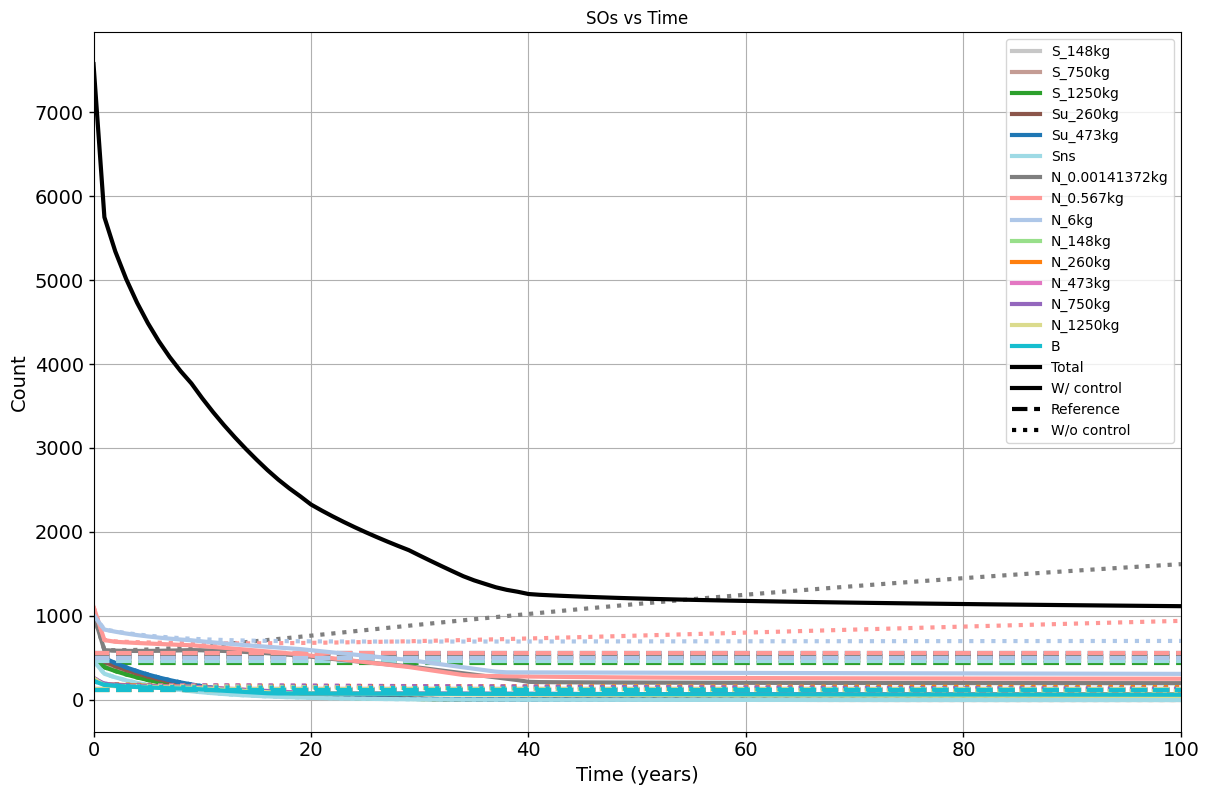

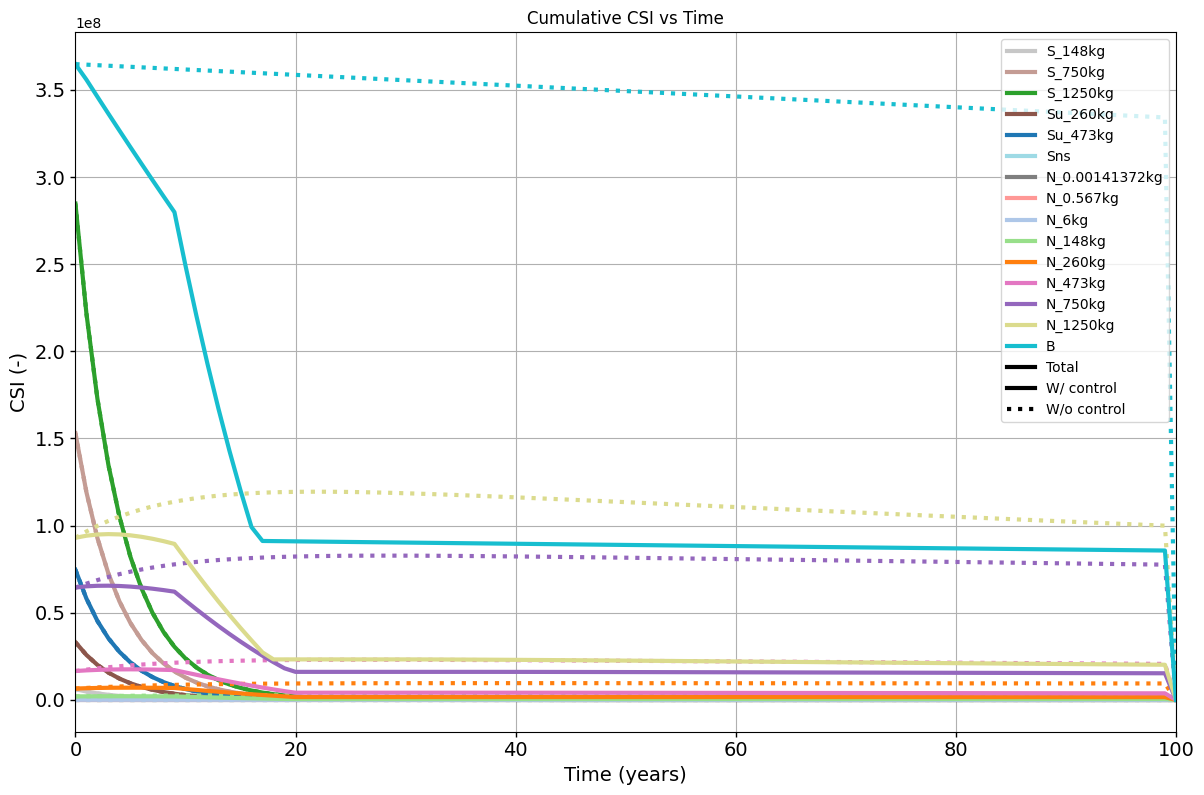

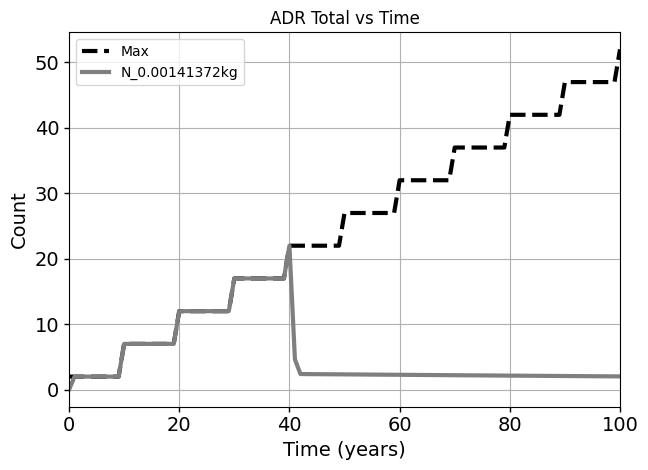

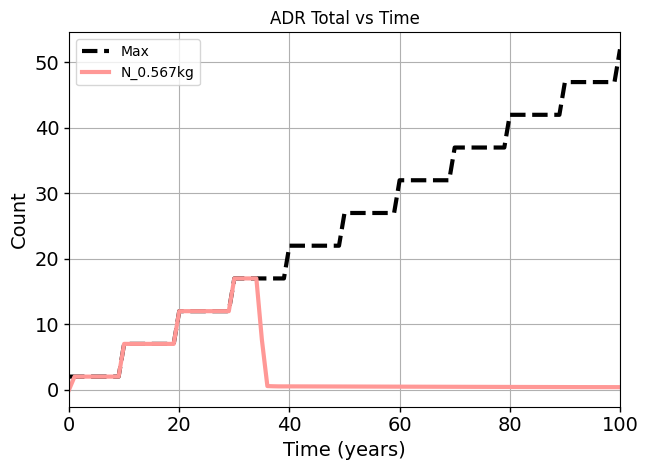

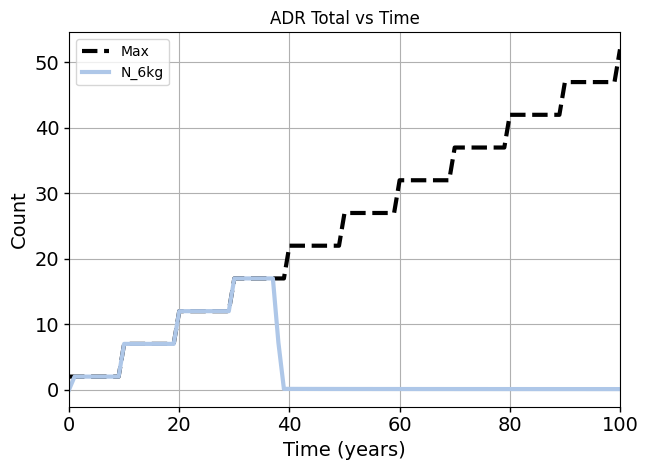

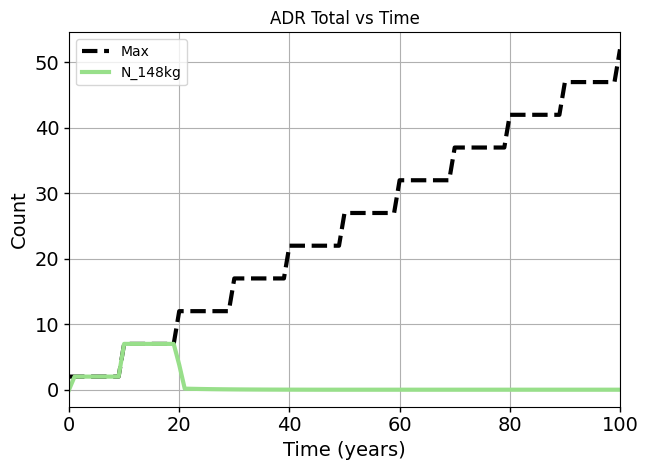

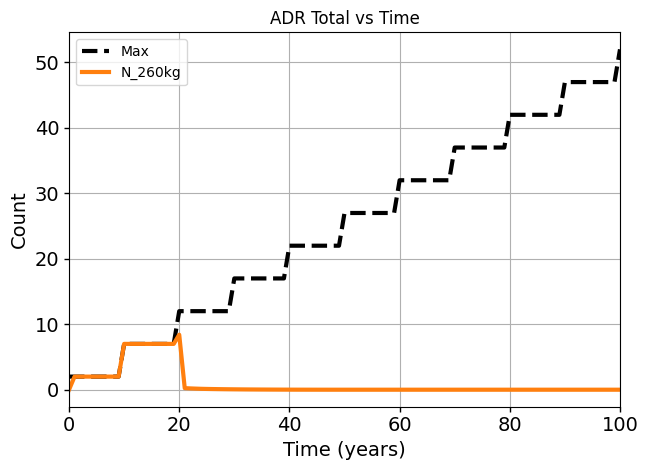

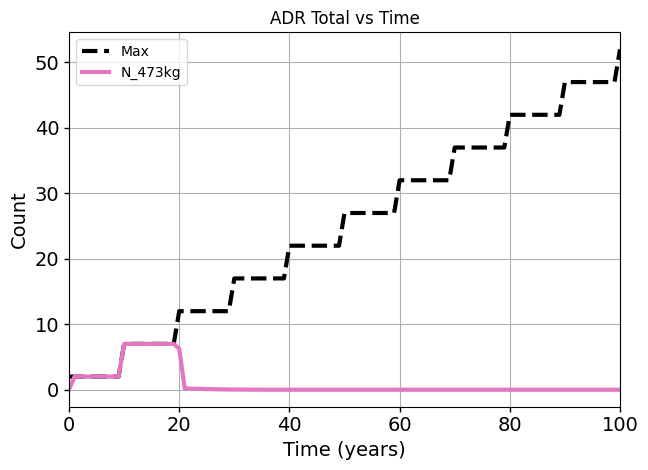

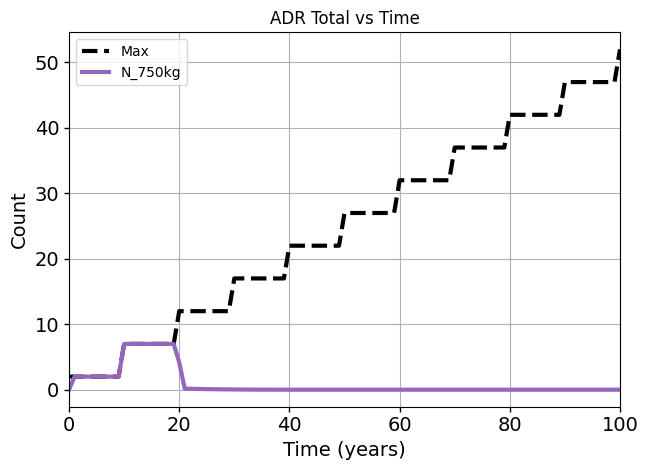

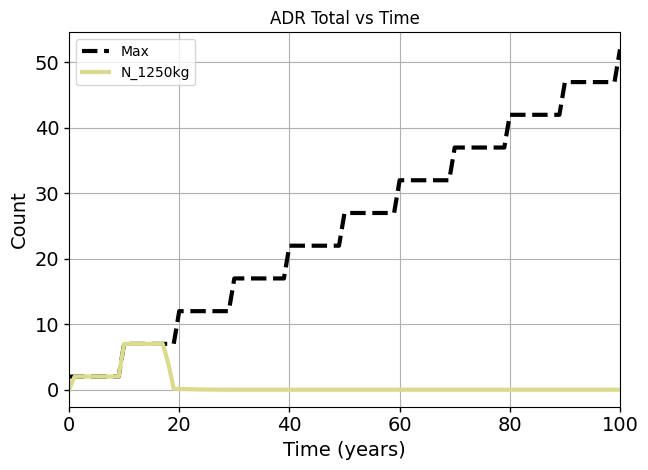

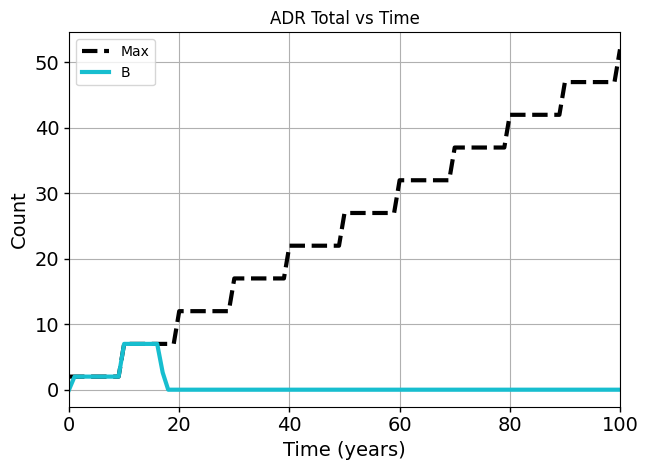

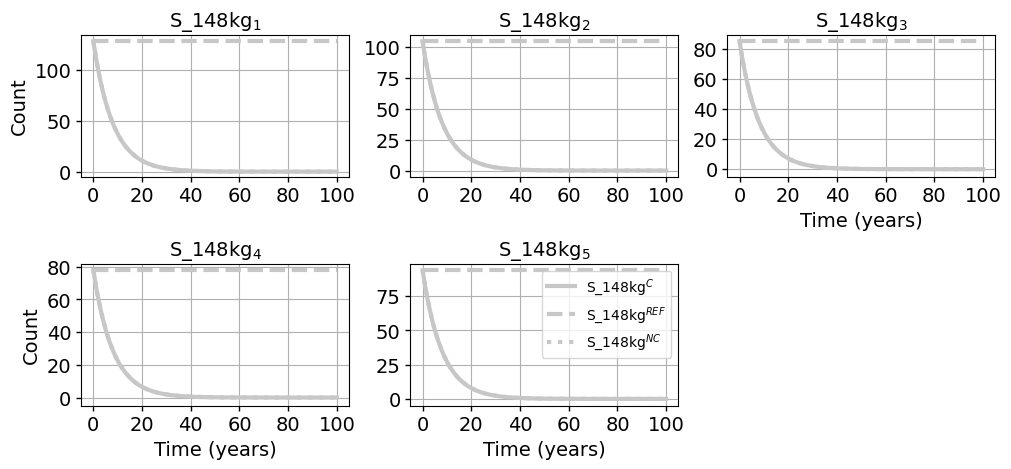

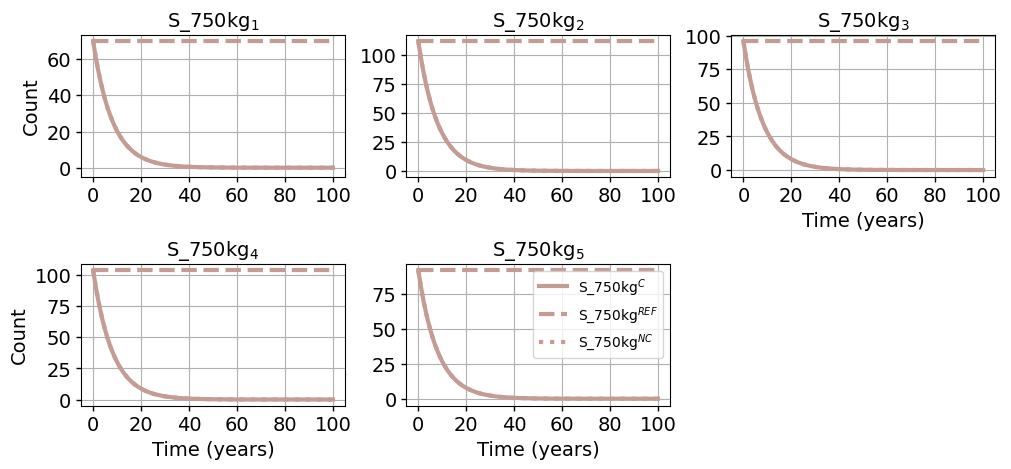

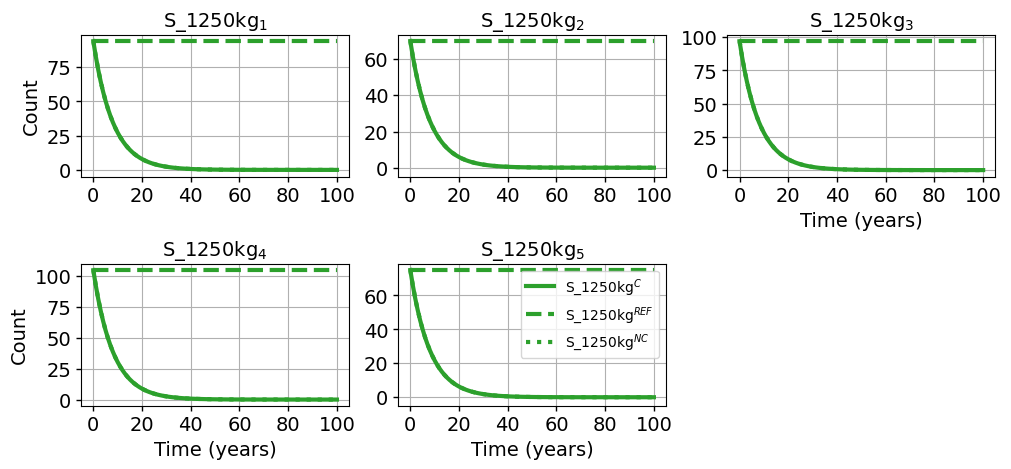

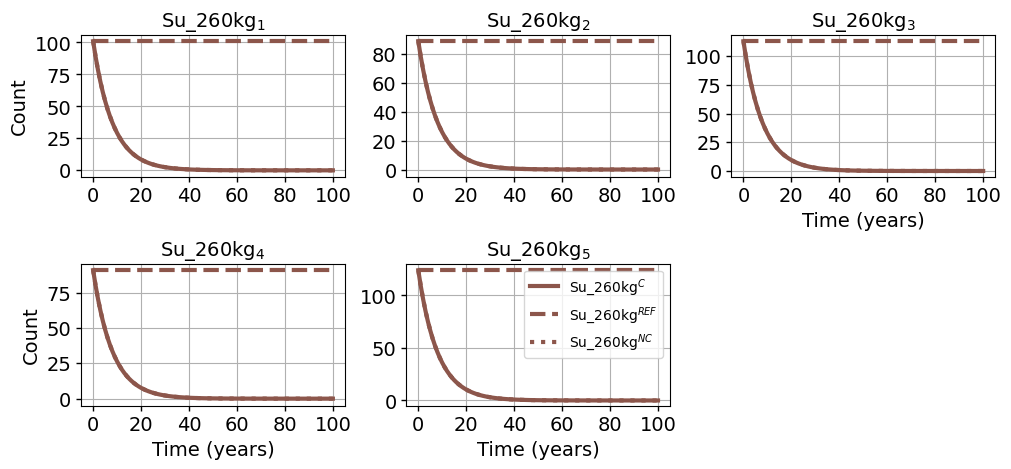

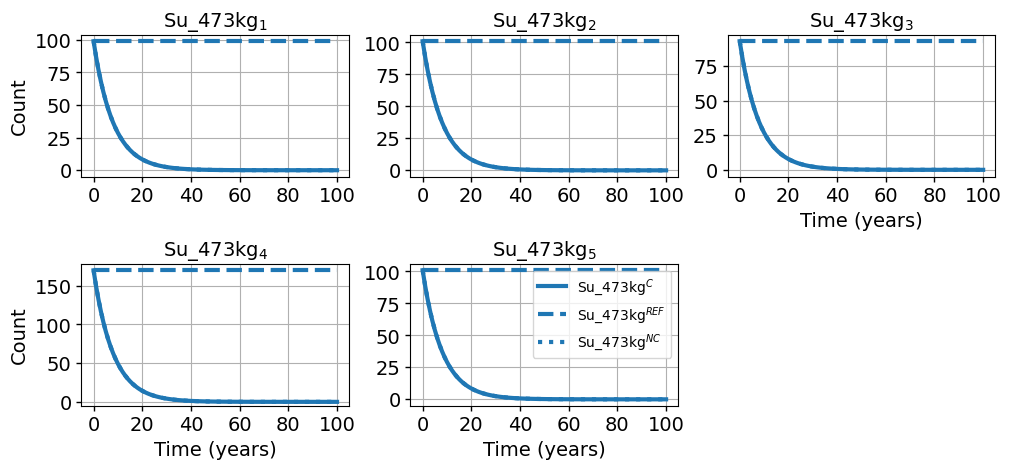

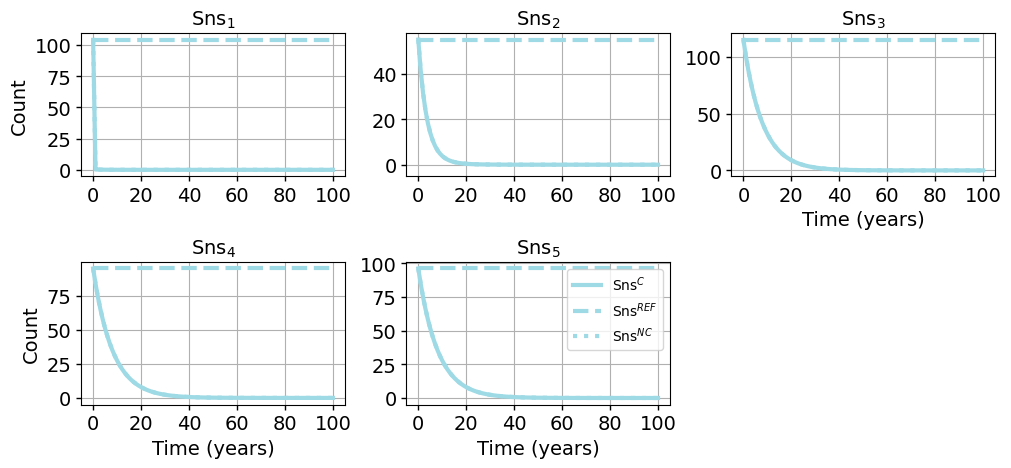

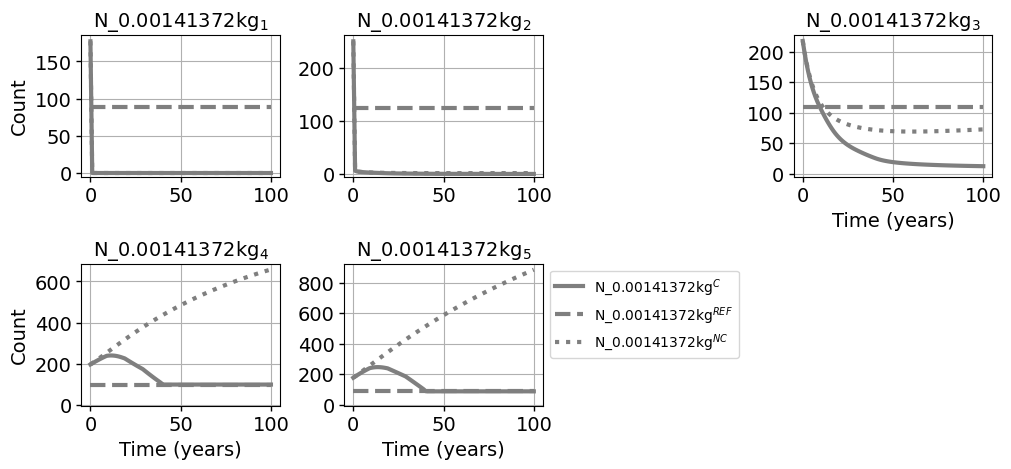

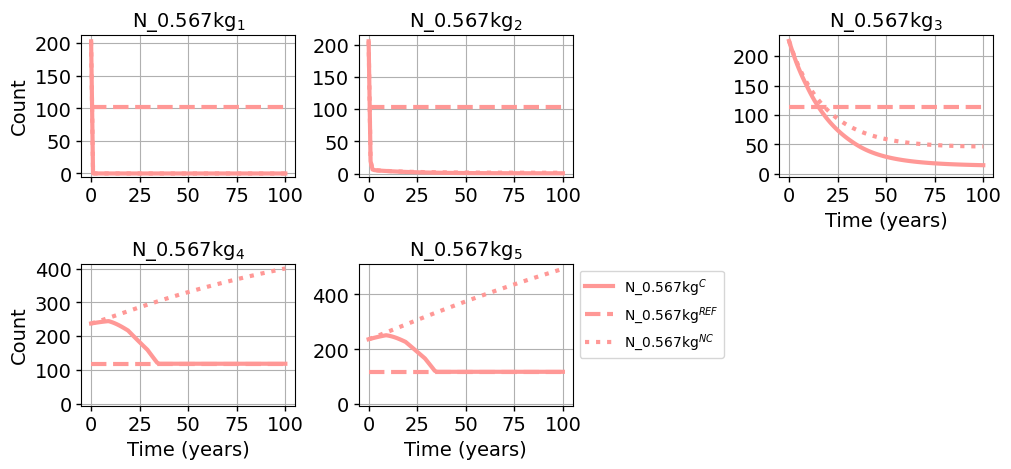

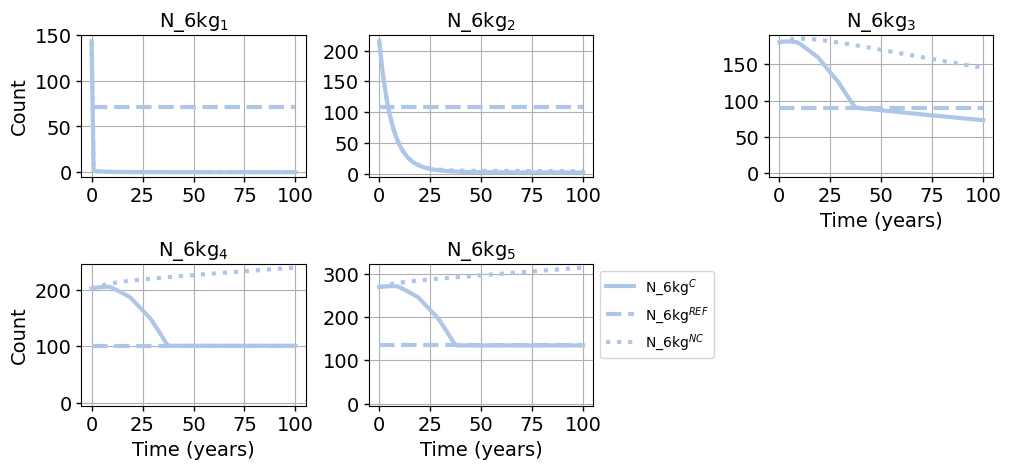

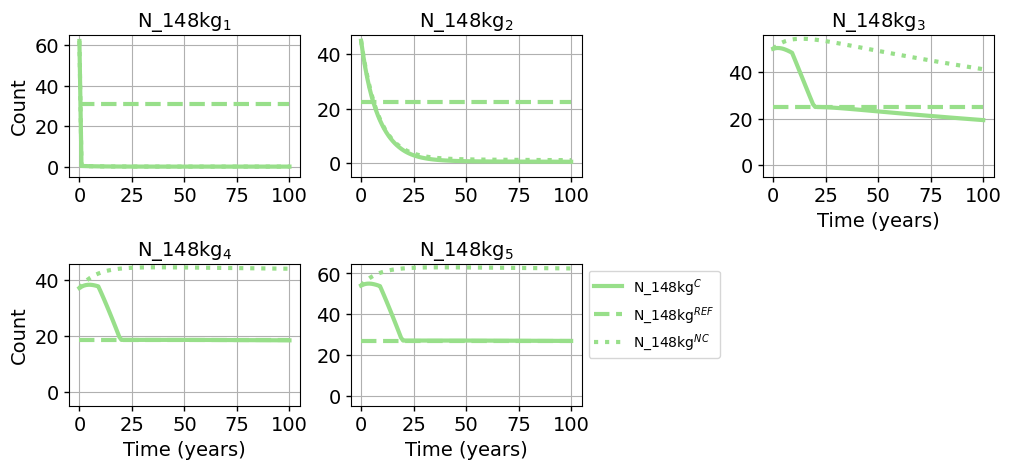

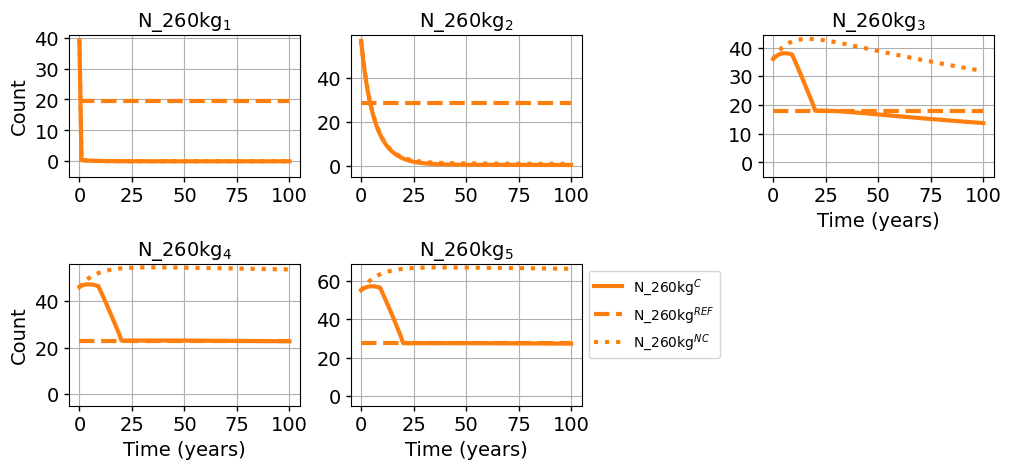

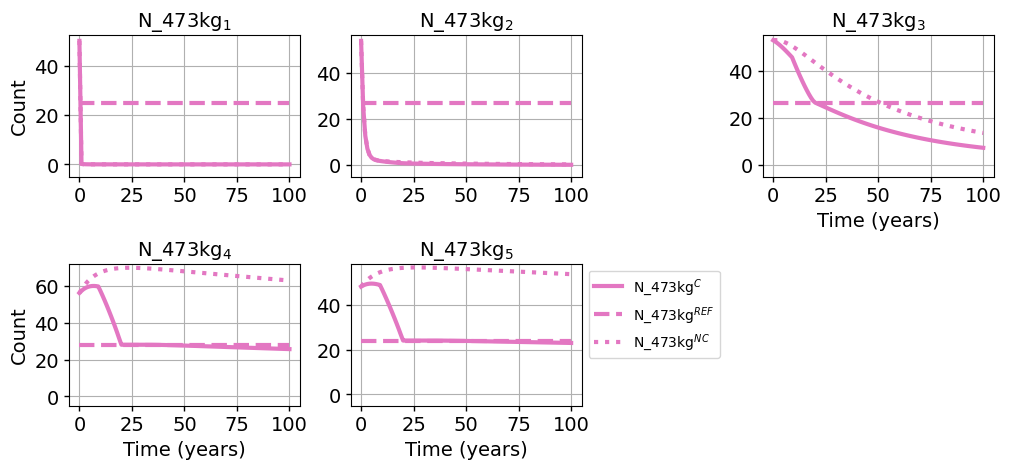

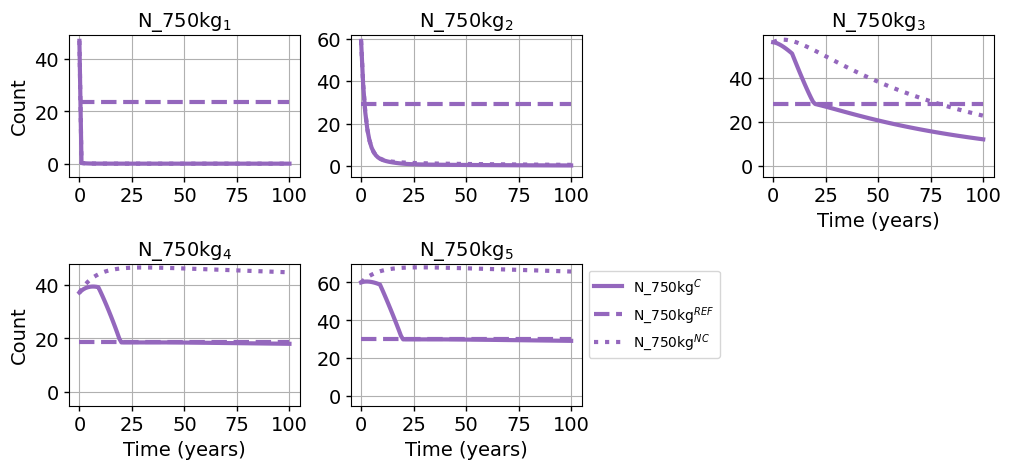

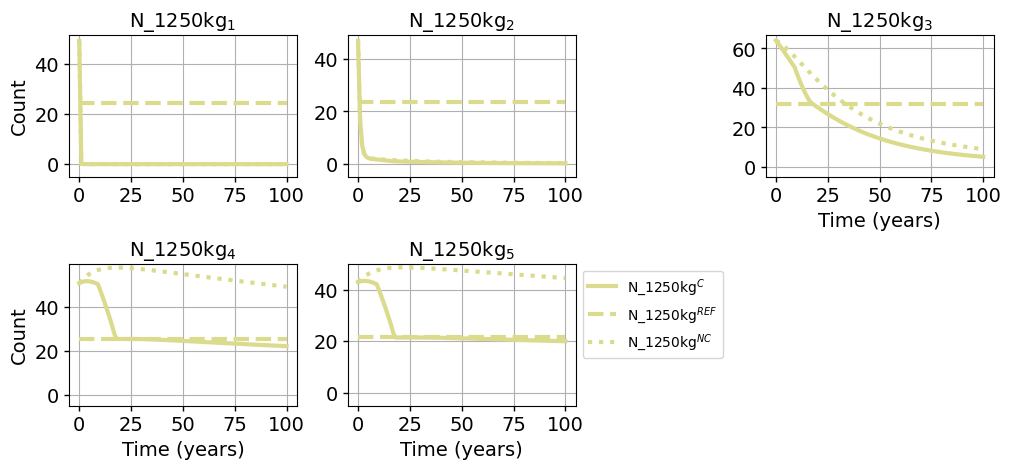

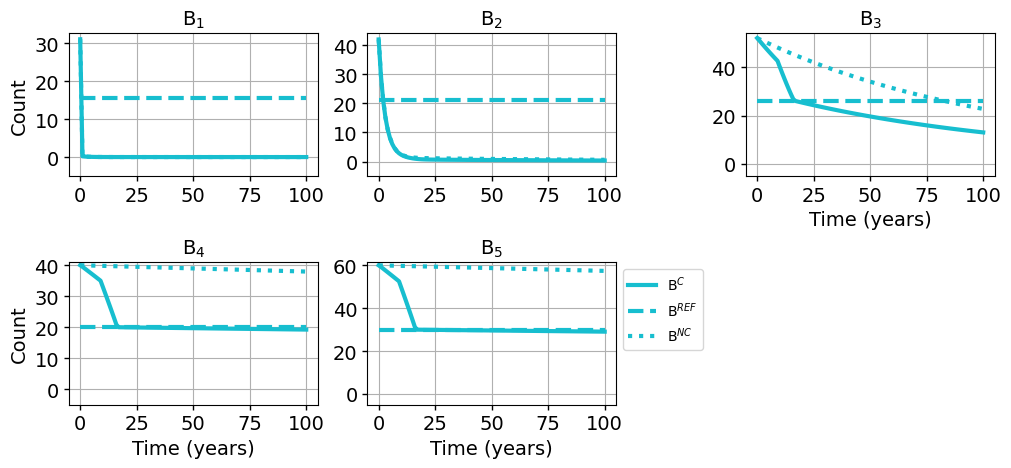

In [100]:
#==========================================================================
# Variable definition for plots
#==========================================================================
# size = (42,101)
baseline.output = {}
baseline.output['t'] = t_prop
baseline.output['y'] = xHistory
baseline.output['y_nc'] = x_prop_nc.T
baseline.output['y_u'] = mvHistory
# if sel_ic == 3:
baseline.output['y_ref'] = np.tile(ref, (len(t_prop), 1)).T
baseline.output['ydot_ref'] = np.tile(ref_dot, (len(t_prop), 1)).T
# else:
#     baseline.output['y_ref'] = np.concatenate([np.tile(ref_S, (len(t_prop), 1)), np.tile(ref_N, (len(t_prop), 1)), np.tile(ref_D, (len(t_prop), 1))], axis=1).T
#     baseline.output['ydot_ref'] = np.concatenate([np.tile(ref_S_dot, (len(t_prop), 1)), np.tile(ref_N_dot, (len(t_prop), 1)), np.tile(ref_D_dot, (len(t_prop), 1))], axis=1).T
# size = (101,)
baseline.output['satur'] = satur
baseline.output['PMD'] = PMD
baseline.output['PMD_no_noise'] = PMD_no_noise
baseline.output['PMD_orig'] = PMD_orig
baseline.output['PMD_no_noise_orig'] = PMD_no_noise_orig

baseline.output['csi_species'] = csi_species.T 
baseline.output['csi_total'] = csi_total
baseline.output['csi_species_nc'] = csi_species_nc.T
baseline.output['csi_total_nc'] = csi_total_nc

output = CreateOutput(baseline.output)
n_species = baseline.species_length
num_shells = baseline.n_shells
species_names = baseline.species_names
orbital_shell_labels = baseline.R0_km[:num_shells]
markers = ['o', 's', '^', 'D', 'v', '>', '<', 'p', '*', 'h']

base_species_names = baseline.species_names
unique_base_species = list(set(base_species_names))
color_map = plt.get_cmap('tab20', len(unique_base_species))

#==========================================================================
# Plots
#==========================================================================
if sel_cumulative_plot == 1:
    cumulative_plot(baseline, output, active_species_indices, sel_pmd_control, sel_risk_index, sel_LineWidth, sel_LineWidthAxis, sel_FontSize)
